In [1]:
!pip install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 34.0 MB/s eta 0:00:00


In [2]:
import torch
import pytorch_lightning as pl
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from matplotlib.pyplot import imshow, figure
import numpy as np
from torchvision.utils import make_grid
import torchvision.transforms as T
import matplotlib.pyplot as plt
import random
from torch.optim.lr_scheduler import OneCycleLR
import torch.optim as optim
from pytorch_lightning.callbacks import LearningRateMonitor

In [3]:
class VAE(pl.LightningModule):
    def __init__(self,enc_out_dim=32, latent_dim=64, featureDim=64*24*24):

        super().__init__()

        # encoder layers
        self.encConv1 = nn.Conv2d(3,32,3)
        self.encConv2 = nn.Conv2d(32,64,3)
        self.fc_mu = nn.Linear(featureDim, latent_dim)
        self.fc_var = nn.Linear(featureDim, latent_dim)

        # decoder layers
        self.deFC1 = nn.Linear(latent_dim, featureDim)
        self.deConv1 = nn.ConvTranspose2d(64,32,3)
        self.deConv2 = nn.ConvTranspose2d(32,1,3)

        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

        # classifier head layers
        self.chConv1 = nn.Conv2d(1, 64, 3)
        self.chout   = nn.Linear(64*26*26,10)
        # classifier loss
        self.bce_loss = nn.BCELoss(reduction = 'none')

    def encoder(self,x):
        x = F.relu(self.encConv1(x))
        x = F.relu(self.encConv2(x))
        x = x.view(x.shape[0], -1)
        return x

    def decoder(self,z):
        x_hat = F.relu(self.deFC1(z))
        x_hat = x_hat.view(-1,64,24,24)
        x_hat = F.relu(self.deConv1(x_hat))
        x_hat = torch.sigmoid(self.deConv2(x_hat))
        return x_hat

    def classifier(self, x):
        x = F.relu(self.chConv1(x))
        x = x.view(x.shape[0],-1)
        x = F.sigmoid(self.chout(x))
        return x

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-4)
        scheduler = OneCycleLR(
                optimizer,
                max_lr= 10**-3,
                pct_start = 5/self.trainer.max_epochs,
                epochs=self.trainer.max_epochs,
                steps_per_epoch=len(train_dataloader),
                div_factor=100,
                three_phase=False,
                final_div_factor=100,
                anneal_strategy='linear'
            )
        return {
             "optimizer": optimizer,
             "lr_scheduler": {"scheduler": scheduler, "interval": "step"},
             }

    def kl_divergence(self,z,mu,std):
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def gaussian_likelihood(self,mean,logscale,sample):
        scale   = torch.exp(logscale)
        dist    = torch.distributions.Normal(mean,scale)
        log_pxz = dist.log_prob(sample)
        return log_pxz.sum(dim=(1,2,3))

    def forward(self,x):
        # encoder
        x_encoded = self.encoder(x)
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)
        std = torch.exp(log_var/2)
        q = torch.distributions.Normal(mu,std)
        z = q.rsample()

        # decoder
        x_decoder = self.decoder(z)

        # multi label classifier
        x_label = self.classifier(x_decoder)

        return x_decoder, x_label,z, mu, std


    def classification_loss(self,x, y):
        ml_loss = self.bce_loss(x, y).sum(dim=1)
        return ml_loss

    def training_step(self,batch,batch_idx):

        x, y, y_changed = batch['images'], batch['correct_labels'], batch['changed_labels']

        # forward pass thru model
        x_hat, x_label, z, mu, std = self(x)

        # vae loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)
        kl = self.kl_divergence(z, mu, std)
        elbo = kl - recon_loss

        # combine y and y changed before sending to bce loss
        y = F.one_hot(y, num_classes = 10).float()
        y_changed = F.one_hot(y_changed, num_classes = 10).float()
        ml_loss_corrected = self.classification_loss(x_label, y)
        ml_loss_changed = self.classification_loss(x_label, y_changed)
        total_loss = (0.35 * ml_loss_corrected)+ (0.35 * ml_loss_changed) + (0.3 * elbo)

        total_loss = total_loss.mean()

        self.log_dict({
            'elbo': (0.01 * elbo).mean(),
            'kl': kl.mean(),
            'classifier loss':(ml_loss_corrected+ml_loss_changed).mean(),
            'total training loss':total_loss
        })
        return total_loss

    def validation_step(self,batch,batch_idx):

        x, y, y_changed = batch['images'], batch['correct_labels'], batch['changed_labels']

        # forward pass thru model
        x_hat, x_label, z, mu, std = self(x)

        # vae loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)
        kl = self.kl_divergence(z, mu, std)
        elbo = kl - recon_loss

        # combine y and y changed before sending to bce loss
        y = F.one_hot(y, num_classes = 10).float()
        y_changed = F.one_hot(y_changed, num_classes = 10).float()
        ml_loss_corrected = self.classification_loss(x_label, y)
        ml_loss_changed = self.classification_loss(x_label, y_changed)
        val_loss = (0.7 * ml_loss_corrected)+ (0.2 * ml_loss_changed) + (0.1 * elbo)

        return val_loss.mean()

In [4]:
import random

def choose_random_number(exclude_number):
    # Create a list of numbers from 0 to 9 excluding the given number
    available_numbers = [num for num in range(10) if num != exclude_number]

    # Choose a random number from the available numbers
    random_number = random.choice(available_numbers)

    return random_number

# function to change the labels of the target
def collate_fn(batch):
    images, correct_labels, changed_labels = [], [], []

    for b in batch:
        img = b[0]
        correct_label = b[1]
        correct_labels.append(torch.tensor(correct_label))
        # Create a tensor of zeros
        tensor_with_corrected = torch.zeros(b[0].size())


        # Set the value at the specified column to 1
        tensor_with_corrected[:, correct_label] = 1
        change_label = choose_random_number(exclude_number = correct_label)
        changed_labels.append(torch.tensor(change_label))
        # Create a tensor of zeros
        tensor_with_changed = torch.zeros(b[0].size())

        # Set the value at the specified column to 1
        tensor_with_changed[:, change_label] = 1

        images.append(torch.cat([img, tensor_with_corrected, tensor_with_changed], dim=0))

    return{
          "images": torch.stack(images, dim=0),
          "correct_labels": torch.vstack(correct_labels).squeeze(1),
          "changed_labels": torch.vstack(changed_labels).squeeze(1)
        }

transform=transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,)),
                                  ])

dataset = MNIST(root='data',train=True,transform=transform ,download=True) # transforms.ToTensor()
train_dataloader = DataLoader(dataset = dataset, batch_size=32,shuffle=True,collate_fn=collate_fn)

dataset_test = MNIST(root='data',train=False,transform=transform, download=True) # transforms.ToTensor()
val_dataloader = DataLoader(dataset = dataset_test, batch_size=32,shuffle=False,collate_fn=collate_fn)

100%|██████████| 9912422/9912422 [00:00<00:00, 92813078.32it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 112579641.10it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32291748.09it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6394940.84it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [5]:
pl.seed_everything(4)
vae = VAE().to('cuda')

trainer = pl.Trainer( max_epochs=30, callbacks=[LearningRateMonitor(logging_interval="step")])
trainer.fit(vae, train_dataloader ,val_dataloader)

INFO:lightning_fabric.utilities.seed:Seed set to 4
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type            | Params
-------------------------------------------------
0 | encConv1     | Conv2d          | 896   
1 | encConv2     | Conv2d          | 18.5 K
2 | fc_mu        | Linear          | 2.4 M 
3 | fc_var       | Linear          | 2.4 M 
4 | deFC1        | Linear          | 2.4 M 
5 | deConv1      | ConvTranspose2d | 18.5 K
6 | deConv2      | ConvTranspose2d | 289   
7 | chConv1      | Conv2d          | 640   
8 | chout        | Linear          | 432 K 
9 | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


In [6]:
torch.save(vae, "./vae_mnist.pth")

In [7]:
def generate_image(val_batch, model, num_predictions=25):
    x, y, y_changed  = val_batch['images'],val_batch['correct_labels'],val_batch['changed_labels']
    figure(figsize=(8, 3), dpi=300)
    t2img = T.ToPILImage()
    with torch.no_grad():
        x_decoder, x_label, z, mu, std = model(x)
        fig = plt.figure(figsize=(10,10))
        for idx in np.arange(num_predictions):
            ax = fig.add_subplot(5,5,idx + 1,xticks=[],yticks=[])
            img = x_decoder[idx].to('cpu')

            plt.imshow(img.permute(1,2,0))
            ax.set_title(f"Label/Image: {y[idx]} / {y_changed[idx]}")
        fig.tight_layout()
        plt.show()

<Figure size 2400x900 with 0 Axes>

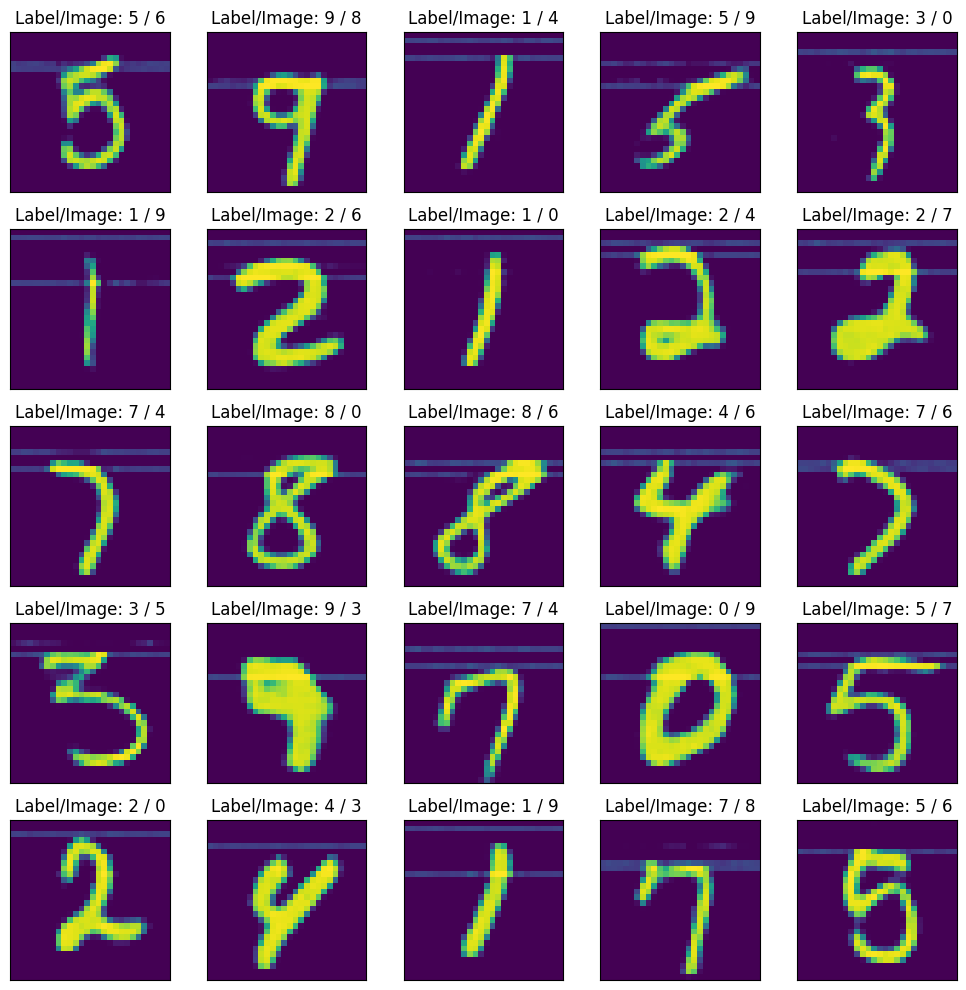

In [8]:
val_batch = next(iter(train_dataloader))
generate_image(val_batch, vae.to('cpu'))